最常见的监督学习问题是分类和回归问题，此章我们利用mnist数据集完成分类问题的探讨

In [2]:
# 引入数据集
from sklearn.datasets import fetch_mldata
import os
import pickle
# 若文件中没存在mnist数据集，则将数据集从网站导入后存入到文件中，
# 若存在直接从文件中获取
if not os.path.exists('mnist.pickle'):
    mnist = fetch_mldata('MNIST original')
    with open('mnist.pickle', 'wb') as wf:
        pickle.dump(mnist, wf)
else:
    with open('mnist.pickle', 'rb') as rf:
        mnist = pickle.load(rf)
        
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X,y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


显示一张图片
每张图片为$28 \times 28$的灰度图，利用matplotlib imshow()函数随机画一张图

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

6.0

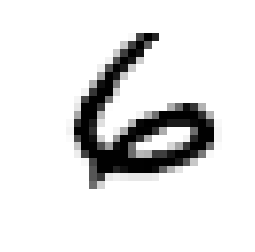

In [5]:
import matplotlib
number = np.random.choice(len(X))
some_digits = X[number]
some_digits_image = some_digits.reshape(28, 28)

plt.imshow(some_digits_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')

y[number]

将数据集分为测试集和训练集， 并将训练集中的数据顺序打乱(shuffle the training set).这将保证所有的交叉验证子集相似，不至于某些子集缺少了某些数字。而且某些学习算法对训练数据个体的顺序十分敏感，如果连续输入很多相似的数据，算法的表现性能很糟糕；但是对于某些时间序列数据而言比如股票票价和天气状况等，打乱顺序并非好事，

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# print(np.unique(y_train))
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

简单点，先训练一个二元分类器(Binary classifier)，比如判断一个数字是否为5.

In [7]:
# 重新更改标签
y_train_5 = (y_train == 5.0 )
y_test_5 = (y_test == 5.0 )
# 检查标签的种类
np.unique(y_train_5)
# print(y_test)
# y_test_5

array([False,  True])

选择基于随机梯度下降（ SGD， stochastic gradient descent）的分类器,该梯度下降算法一次只使用一个样本训练算法，更容易处理大量训练数据，所以SGD也适合于在线学习（online learning）.创建一个SGDClassifier

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [9]:
# 检测图像  上文中some_digits
sgd_clf.predict([some_digits])

array([False])

评估一个分类器通常要比评估回归模型更困难，更具有技巧性，所以本章大多数讨论的主题都是评估问题，

1.使用交叉验证测量准确率
自己实现交叉验证函数，
 * StratifiedKFold完成分层抽样，即将数据分成k个folds.然后StratifiedKFold.split返回k个元组的生成器，每个元组的第一个值为训练索引，第二个值为验证索引值
 * clone(estimator) : Constructs a new estimator with the same parameters. 使用与estimator相同的参数新创建一个新的estimator
 

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
# 分为3个folds
skfolds = StratifiedKFold(n_splits=3, random_state=42)
# print(list(skfolds.split(X_train, y_train_5)))
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # print(train_index.shape,test_index)
    
    #先创建一个新的estimator
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    
    # out: 0.95815 0.9539 0.96885

E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.92935


E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.96545


E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9593


In [11]:
# 使用sklearn提供的cross_val_score函数
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-package

array([0.92935, 0.96545, 0.9593 ])

### confusion matrix

  将类A分类为B的次数，比如你想查看将5识别为3的次数，你可以查看矩阵的第5行第3列。
  在计算混淆矩阵(confusion matrix)之前，先需要预测值，以便于与真实值比较，当然可以在测试集（test set）上预测，但是现在现不在测试集上预测（切记，只有在项目的最后再能使用测试集），可以使用cross_val_predict()在训练集上预测代替。
  和cross_val_score()函数相似，cross_val_predict()也在k个子集上做交叉验证，但返回的不是评估分数，而是在每个测试集上的预测值。简单的就是，每次在k-1个子集上训练，而在余下的1个子集上预测。
  以下就是利用cross_val_predict()和confusion_matrix()函数获得混淆矩阵的例子
  

In [12]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-package

array([[52660,  1919],
       [  999,  4422]], dtype=int64)

在混淆矩阵中，每一行为真实的类别（actual class），每一列为预测的类别（predict class），比如第一行的类别为不是5（被称为 the negative class）的图片，有51532被正确的分类(true negativse)，而有3047的图片被分为5(false positives)，第二行的类别为5（the positive class），有1391的图片分类为不是5（false negatives），有4030的图片分类为 true positives）；注意到**positive或negative依据的是预测的类别**

几个描述分类结果的度量标准(metric):
* precision:

预测为真的分类中，真正为真的类别所占的比列

  $$precision = \frac{TP}{TP +FP}$$

* recall (sensitivity true positive rate(TPR)):

真正为真的分类中，预测为真的类别所占的比列

$$recall = \frac{TP}{TP+FN}$$

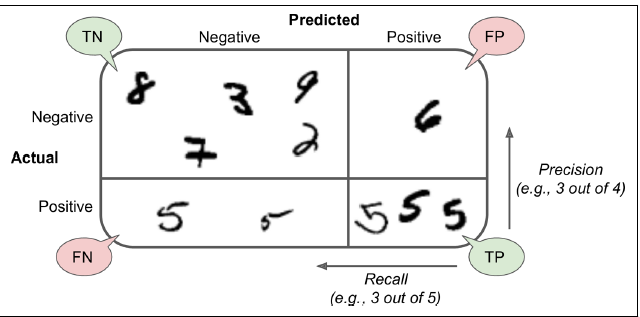



计算precision和recall

In [93]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)


ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [94]:
4422 / (1919 +4422)

0.6973663460022078

In [21]:
recall_score(y_train_5, y_train_pred)

0.8157166574432761

In [95]:
4422 / (4422 +999)

0.8157166574432761

预测为5的类别只有大约为70%预测正确，而真正为5的类别只有约81%预测出来。

F1的定义，将precision和recall结合起来，如果precision和recall很高，（这是我们对一个优秀的算法所期待的），那么F1将很高

$$F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$

In [13]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7519129399761946

在一些场合下我们关注precision,而在另一些场合下，我们更关注recall，比如，如果你想训练一个分类器来检测出对孩子而言安全的视频，你更想可以拒绝很多安全的视频（low call），但是保留的视频最好是全是安全的（high precision），而在另一个场合下，你训练另一个通过商店监控视频分类小偷的分类器，你希望宁可只有30%的precision却必须要有99%的recall.

但是却不能同时使两者都很高，增加precision必然伴随着降低recall，反之亦然，被称为“precision/recall tradeoff”
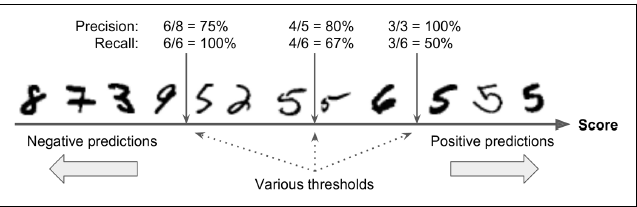

让我们通过上图来了解一下，precision/recall tradeoff：
对于每一个图片，SGDClassifier首先会根据decision function计算一个
分数（score），如果该分数大于某一个阈值（threshold），则分为positive 类，否则分为negative类，首先假设threshold是上图中间的箭头，则此时precision为5个识别为5的手写字体中有4个为5，即4/5=0.8,而真正为5的6个手写字体中识别出来4个，即4/6=0.67,而此时若提高阈值到右边的箭头则，precision=3/3=1,reall=3/6=0.5,同样降低阈值，则提高了recall而降低了precision


sklearn不允许你直接设定阈值（threshold），却允许你通过使用决策分数（decision score）来做预测。

不再调用分类器的`predict()`函数，调用`decision_function()`函数，该函数返回的是每一幅图片（每一个实例个体）的分数，接下来基于得到的分数，使用你想设定的阈值来判断



In [14]:
y_scores = sgd_clf.decision_function([some_digits])
y_scores

array([-413834.30335973])

In [15]:
threshold = -600000
y_some_dogit_perd = (y_scores > threshold)
y_some_dogit_perd

array([ True])

SGDClassfier使用的阈值threshold为0，所以返回结果为假

那么，如何确定使用什么阈值呢？仍然使用cross_val_predict()函数，指定method参数为decision_function,获得验证集上所有实例的得分。

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-package

使用得到的分数，对于所有可能的阈值，可以使用precision_recall_curve函数来计算precision和recall



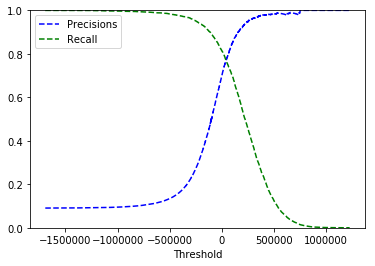

In [17]:
from sklearn.metrics import precision_recall_curve
precisions, recalls , threshold = precision_recall_curve(y_train_5, y_scores)
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# 使用matplotlib画图片
# 注意precisions和recalls的长度与threshold不一致，大1
def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
    
    plt.plot(threshold, precisions[:-1 ], "b--", label="Precisions")
    plt.plot(threshold, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, threshold)
plt.show()

注意上图中，Precisions的曲线要比Recalls更加不平滑，那是因为当提高阈值时，precision可能会降低，而recall则一定会降低，看一下之前讲述precision和recall的例子，可得，当提高阈值时， 原来识别为5的图片未识别出来导致，precision从4/5=0.8讲到了3/4=0.75.

也可以直接画出precision和recall的变化曲线

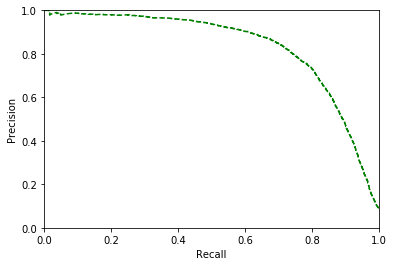

In [18]:
def plot_precision_vs_recall(precisions, recalls):
    
    plt.plot(recalls, precisions, "g--")
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    

plot_precision_vs_recall(precisions, recalls)


从图中可以看出，recall从60%出开始快速下降，假设选择90%的precision，看第一个图，发现大概threshold大约为65000，此时再预测新的数据时， 不在调用predict()函数，而是先调用`decision_function()`,获得y_scores，然后使用设定的阈值预测

In [22]:
y_train_pred_90 = (y_scores > 70000)
# 判断此时的precision和recall
#不幸的是，precision达不到要求
precision_score(y_train_5, y_train_pred_90)


0.8066599394550958

In [23]:

recall_score(y_train_5, y_train_pred_90)

0.7373178380372625

ROC曲线（receiever operating characteristic）与precision/recall曲线相似，但刻画的是true positive rate[TPR]（recall的另一个名字）和false positive rate[FPR]之间的关系。FPR是错误的被分为正样本的负样本的个数与负样本个数的比值，等于 $1 - TNR$, TNR(true negative rate)：负样本中被正确分为负样本的个数与负样本个数的比值，TNR也被称为specificity，因此ROC曲线刻画的是sensitivity（recall）和 1 - specificity之间的关系。

先计算TPR和FPR，使用roc_curve()函数

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

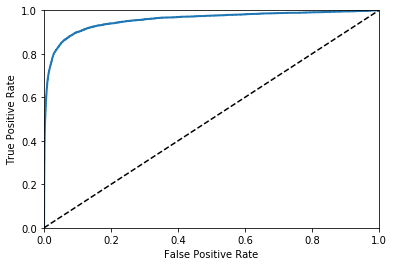

In [25]:
# plot roc
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

plot_roc_curve(fpr, tpr)

在图中仍然看出tradeoff, 随着recall（TPR）的升高，分类器产生更多的false positive（FPR），虚线代表的是纯随机分类器（purely random classifier），一个好的分类器永高尽可能的远离虚线，尽可能的靠近左上角

一种类比较分类器好坏的方法是测量AUC(area under the curve),一个完美的分类器AUC = 1，一个纯随机分类的AUC=0.5，可以使用`roc_auc_score`来计算AUC的值

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.956021054307335

既然ROC和PR曲线类似，那使用哪一个呢？

经验法则是，当正样本很少，或者更关心false positives（预测结果将多少负样本预测为正样本） 而非false negatives（预测结果将多少正样本预测为负样本）使用PR， 否则使用ROC。

比如从ROC曲线可以看出分类器表现已经很好，那是因为5
的种类要远少于non-5 ，而从PR曲线却可以看出，分类器还可以提升，更加靠近右上角

接下来训练一个随机森林的分类器（RandomFroestClassifier），与SGDClassifier比较一下

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")


RandonForestClassifier 并没有`decision_function()`函数，有一个`predict_proba()`函数，返回的是二维数组，每一个样本为一行，预测的类别为列，每一列中数值为该样本预测属于该类别的概率 

In [28]:
#前5个样本的概率， 第一列为non-5， 第二列为5
y_probas_forest[:5]


array([[1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

要画曲线，需要分数，而非概率，简单的，可以是使用每个实例为5的概率作为分数

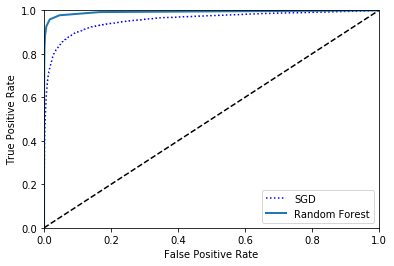

In [29]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_fprest = roc_curve(y_train_5, y_scores_forest)

# 画
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

从图中看出，随机森林分类器的表现性能更好一点。


In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.9924050155627879

In [31]:
#大于0.5为True， 否则为False
# import numpy as np

# a = np.array([0, 1, 0.7, 0.2])
# a = a > 0.5
# a
y_scores_forest_pred = y_scores_forest > 0.5
precision_score(y_train_5, y_scores_forest_pred)


0.9856891237340378

In [32]:
recall_score(y_train_5, y_scores_forest_pred)

0.8258623870134661

可以看出大约98.5%的precision， 82.8%的recall,模型的表现不算错，


Multiclass Classification

至于多类分类器，可以使用Random Forest classifier或者naive Bayes classifier直接进行多类分类，而至于svm和linear classifier则是二元分类器（binary classifier），当然可以使用多个二元分类器来实现多元分类，以上是一些常用的方法。
* 比如要分类0~9,，可以训练10个二元分类器，每一个分类器负责分类一个数字，（0-detector， 1-dector， 2-dector），当要识别一个图片时，利用10个二元分类器预测，分数最高的那个二元分类器就是识别的数字，称为**one-versus-all（OvA）strategy**， 也叫one-versus-the-rest

* 另一种策略是为每两个数字单独训练一个二元分类器，比如 0s-1s， 1s-2s，2s-3s，比如要区分N类，则需要$N \times (N - 1) / 2$个二元分类器。这被称之为**OvO（one-versus-one）strategy**， 要分10个数字需要训练45个二元分类器，当要识别一个手写字体时， 将图像分别喂给45个分类器，看一下最后45个分类器的输出结果中哪一个类别占的数量最多，就是哪一类。优点是对于每一个分类器训练时，只需要使用训练集中对应两个类别的数据就好。

对于一些算法（svm）其训练速度及表现会随着训练集的增大而迅速变差，因此对于这些算法，OvO表现的很好，因为相比于在大数据集上训练分类器，在小数据集上训练的速度会更快。但是对于大多数二元分类算法，OvA更好

当使用二元分类算法分类多元任务时，sklearn会自动使用OvA（当使用svm classifer时，使用OvO方法）

In [33]:
# 使用SGDClassifier分类器在数据及上训练
sgd_clf.fit(X_train, y_train)
# 预测
sgd_clf.predict([some_digits])

E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([6.])

实际上sklearn训练了10个二元分类器，得到图像的10个分数，然后分数最高的那个类别是预测结果。
接下来使用`decision_function()`函数来看一下过程，此时返回的是10个分数

In [34]:
some_digits_scores = sgd_clf.decision_function([some_digits])
some_digits_scores

array([[-595663.21955387, -877340.07369729,  -97322.79677218,
        -775219.39150077, -187594.85072678, -413834.30335973,
         549962.55145472, -604738.90260495, -793937.08372435,
        -588881.53014329]])

In [35]:
pos = np.argmax(some_digits_scores)
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [36]:
sgd_clf.classes_[pos]

6.0

**注意：**当一个分类器在训练时，在class_属性中存储类别的列表，按照值有小到大排序

如果想指定sklearn使用one-versus-one 或者 one-versus-all方法呢？使用OneVsOneClassifier或者OneVsRestClassifier类，下面是基于SGDClassifier使用OvO方法训练分类器

In [37]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
# 预测
pre_dig = ovo_clf.predict([some_digits])
pre_dig


E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-package

E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-package

E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-package

array([6.])

In [38]:
# 二元分类器的数量
len(ovo_clf.estimators_)

45

In [39]:
# 随机森林分类器
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digits])

array([6.])

注意这次sklearn并没有使用OvO或者OvA，因为随机森林分类器可以直接进行多元分类，使用`predict_proba()`获得属于各类别的概率


In [40]:
forest_clf.predict_proba([some_digits])

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

当然可以使用`cross_val_score()`验证算法在验证集上的准确率（accuracy）

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-package

array([0.84953009, 0.87074354, 0.84912737])

In [43]:
# 对输入数据做standardization处理 去均值和方差归一化
# 效果会好一点

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train.shape
# 


(60000, 784)

In [44]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-package

array([0.90746851, 0.90989549, 0.91048657])

Error Analysis

当然如果是一个真正的项目需要按照以下步骤：数据预处理，实现多个模型，选出最好的模型，使用`GridSearchCV`来微调超参数，尽可能实现自动化。

在这里，假设已经发现一个好的模型，并且希望继续优化此模型，一种方法是分析预测错误的类型，

首先需要看一下混淆矩阵（confusion matrix），首先使用`cross_val_predict()`预测，然后调用`confusion_matrix()`获得混淆矩阵


In [45]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
E:\work_file\anaconda\lib\site-package

array([[5724,    3,   25,   12,   11,   49,   48,    8,   40,    3],
       [   1, 6480,   42,   24,    6,   41,    7,   11,  117,   13],
       [  62,   34, 5333,   96,   83,   23,   93,   54,  166,   14],
       [  46,   42,  138, 5336,    3,  233,   38,   54,  144,   97],
       [  21,   26,   39,   10, 5380,   10,   48,   25,   88,  195],
       [  76,   40,   38,  193,   76, 4592,  108,   34,  175,   89],
       [  38,   25,   44,    1,   38,   90, 5630,    4,   48,    0],
       [  28,   23,   64,   33,   64,    9,    6, 5788,   15,  235],
       [  56,  148,   72,  151,   15,  159,   52,   30, 5033,  135],
       [  47,   27,   30,   83,  175,   35,    3,  214,   74, 5261]],
      dtype=int64)

有很多数字，并不直观，我们来看一下confusion matrix的图像表示

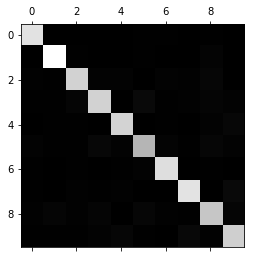

In [46]:
plt.matshow(conf_mx, cmap=plt.cm.gray)


混淆矩阵看起来已经很好了，因为大多数图像都在住对角线上，都被正确的分类了。但是5看起来要比其他的数字要暗一些，或许是因为数据集中5的照片较少，也可能是5被正确分类的照片较少。

计算错误率：将每行中每一个数除以该行所代表的数字的图像总数（该行的和）

In [47]:
# 计算行和
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums.shape

(10, 1)

broadcast: 按位+ - * /

两个数组的shape满足以下要求：
* 相等
* 某一维度为1
* 某一个shape的len要小于另一个，但是对于短的那个shape最后到前依次满足上面两条

例子：
```python
Image  (3d array): 256 x 256 x 3
Scale  (1d array):             3
Result (3d array): 256 x 256 x 3
    
    
A      (2d array):  5 x 4
B      (1d array):      1
Result (2d array):  5 x 4

A      (2d array):  5 x 4
B      (1d array):      4
Result (2d array):  5 x 4

A      (3d array):  15 x 3 x 5
B      (3d array):  15 x 1 x 5
Result (3d array):  15 x 3 x 5

A      (3d array):  15 x 3 x 5
B      (2d array):       3 x 5
Result (3d array):  15 x 3 x 5

A      (3d array):  15 x 3 x 5
B      (2d array):       3 x 1
Result (3d array):  15 x 3 x 5
```

In [48]:
norm_conf_mx = conf_mx / row_sums
norm_conf_mx.shape

(10, 10)

要比较错误率，将对角线上用0填充，其余地方越亮表示识别错误率越高

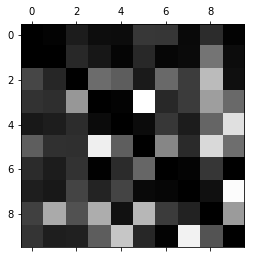

In [49]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)


注意第8,9列很亮，说明8,9有很多分类错误，同时第8,9行也很亮，说明8,9很容易被分类错误，容易与其他数字混淆，而1都很暗，表明分类很好。

从图中看出，主要通过以下两方面来提升性能
* 提升8和9的分类性能
* 区分3 和5的

解决方法：
1. 可以在收集这些数字更多的图像，
2. 发掘新的特征， 比如数字闭环的个数（8有2个， 6有1个， 5没有）
3. 使用sklearn,pillow, opencv使图像的某些模式更加明显，比如闭环

分析个别错误也可以深入了解分类器如何工作及为何会失败。但是更加困难并且耗时，下面看一下3s和5s

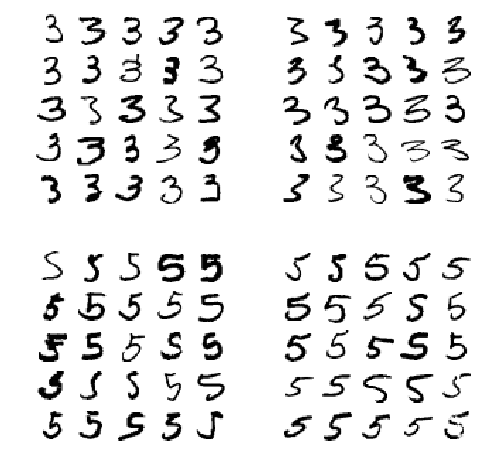

In [81]:
cl_a, cl_b = 3, 5
# 获得四类图像
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

        
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Multilabel Classification  多标签分类

每一个个体输出多个标签，比如，在一个人脸识别系统中，在一张图片中识别多个人,假设分类器被训练识别三个人 Alice, Bob, Charlie;接下来当图片中只有Alice和Charlie，此时输出用为[1, 0,1]，即(Alice yes Bob no Charlie yes).
类似这种输出第一个二元标签的分类系统，陈称为多标签分类系统(multilabel classification system)

看一个简单的例子，

In [83]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
# 按列合并
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel.shape


(60000, 2)

In [84]:
# 每个个体有两个标签
y_multilabel[:3]

array([[False, False],
       [False, False],
       [ True,  True]])

In [85]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# 预测 some_digits [6]
knn_clf.predict([some_digits])
#  不大并且为偶数，输出

array([[False, False]])

Multioutput Classification
是多标签分类的扩展，对于每一个标签，可能有多个类别（比如有超过两个可能的值）

训练一个从图像中除去噪声的系统，来说明Multioutput Classification。
接受一个有噪声的图片，输出一个去噪后的图片，输出为一维数组，长度为784，注意，分类器的输出是多标签的（每个像素一个标签），并且每个像素的值从0~255变化。

也就是说分类器接受一个图片，输出为长度为784的一维数组，每个值取值为0~255.

**注意:** 分类和回归之间的界限有时候并不会那么清晰，比如在这个例子中，预测像素值更像是一个回归问题，而非分类问题。当然，多输出系统（multioutput system）并不仅仅局限于分类任务，甚至可以在一个系统中为每一个个体输出多个标签，标签包括类标签和值标签（class label and value label）



先创建一个训练集和测试集，其中特征值（x）为在原图像上添加噪声，标签（y）为原图像的值


In [86]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

从测试集中找一个图片看一下

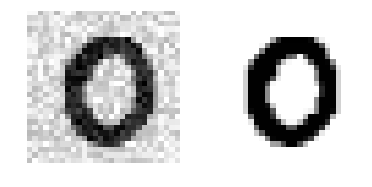

In [88]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show()


In [91]:
# 训练模型然后测试
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])



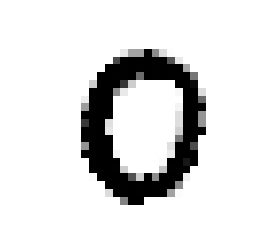

In [92]:
plot_digit(clean_digit)

输出效果还不差哦